## Loading a model from a checkpoint

In [1]:
import os
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.framework import graph_util

In [3]:
def linearLayer(x, n_output, name=None, activation=None, reuse=None):
    """Fully connected layer.
    Parameters
    ----------
    x : tf.Tensor
        Input tensor to connect
    n_output : int
        Number of output neurons
    name : None, optional
        Scope to apply
    Returns
    -------
    h, W : tf.Tensor, tf.Tensor
        Output of fully connected layer and the weight matrix
    """
    if len(x.get_shape()) != 2:
        x = flatten(x, reuse=reuse)

    n_input = x.get_shape().as_list()[1]

    with tf.variable_scope(name or "fc", reuse=reuse):
        W = tf.get_variable(
            name='W',
            shape=[n_input, n_output],
            dtype=tf.float32,
            initializer=tf.contrib.layers.xavier_initializer())

        b = tf.get_variable(
            name='b',
            shape=[n_output],
            dtype=tf.float32,
            initializer=tf.constant_initializer(0.0))

        h = tf.nn.bias_add(
            name='h',
            value=tf.matmul(x, W),
            bias=b)

        if activation:
            h = activation(h)

        return h, W
    
def flatten(x, name=None, reuse=None):
    """Flatten Tensor to 2-dimensions.
    Parameters
    ----------
    x : tf.Tensor
        Input tensor to flatten.
    name : None, optional
        Variable scope for flatten operations
    Returns
    -------
    flattened : tf.Tensor
        Flattened tensor.
    """
    with tf.variable_scope('flatten'):
        dims = x.get_shape().as_list()
        if len(dims) == 4:
            flattened = tf.reshape(
                x,
                shape=[-1, dims[1] * dims[2] * dims[3]])
        elif len(dims) == 2 or len(dims) == 1:
            flattened = x
        else:
            raise ValueError('Expected n dimensions of 1, 2 or 4.  Found:',
                             len(dims))

        return flattened

In [3]:
# Need to first define all tensors in model, as if starting from scratch

n_features = 784
n_labels = 10
width = 28

X = tf.placeholder(tf.float32, [None, n_features])
Y = tf.placeholder(tf.float32, [None, n_labels])

# Need to reshape b/c doing convolutions
X_tensor = tf.reshape(X, [-1, width, width, 1])

# Define first layer
filter_size = 5
n_filters_in = 1
n_filters_out = 32

W_1 = tf.get_variable(
    name='W',
    shape=[filter_size, filter_size, n_filters_in, n_filters_out],
    initializer=tf.random_normal_initializer())

b_1 = tf.get_variable(
    name='b',
    shape=[n_filters_out],
    initializer=tf.constant_initializer())

h_1 = tf.nn.relu(
    tf.nn.bias_add(
        tf.nn.conv2d(input=X_tensor,
                     filter=W_1,
                     strides=[1, 2, 2, 1],
                     padding='SAME'),
                    b_1))

# Define second layer
n_filters_in = 32
n_filters_out = 64

W_2 = tf.get_variable(
    name='W2',
    shape=[filter_size, filter_size, n_filters_in, n_filters_out],
    initializer=tf.random_normal_initializer())

b_2 = tf.get_variable(
    name='b2',
    shape=[n_filters_out],
    initializer=tf.constant_initializer())

h_2 = tf.nn.relu(
    tf.nn.bias_add(
        tf.nn.conv2d(input=h_1,
                 filter=W_2,
                 strides=[1, 2, 2, 1],
                 padding='SAME'),
                 b_2))

# Now connect to a fully-connected/linear layer:
magicNum = 7  # ??
h_2_flat = tf.reshape(h_2, [-1, magicNum * magicNum * n_filters_out])

n_out = 128
h_3, W = linearLayer(h_2_flat, n_out, activation=tf.nn.relu, name='fc_1')

# And one final FC layer & softmax to get probs
Y_pred, W = linearLayer(h_3, n_labels, activation=tf.nn.softmax, name='fc_2')

# Define loss fxn in same way
cross_entropy = -tf.reduce_sum(Y * tf.log(Y_pred + 1e-12))
optimizer = tf.train.AdamOptimizer().minimize(cross_entropy)

# with accuracy for our monitoring
correct_prediction = tf.equal(tf.argmax(Y_pred, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

In [4]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())
saver = tf.train.Saver()

FN = "/Users/kateniehaus/Dropbox/machine learning/Deep/Kadenze/model_4layerconvnet-mnist.ckpt"

if os.path.exists(FN):
    saver.restore(sess, FN)
    print("Model restored.")

Model restored.


In [5]:
# Now look at layers again to check if same
# Look at layers inside
W1 = sess.run(W_1)

In [7]:
def plotLayerRaw(W, figsize=[8,8], dim2=0):
    """ Plots pcolormesh of learned filter weights"""
    numR = int(np.ceil(np.sqrt(W.shape[3])))
    plt.figure(figsize=figsize)
    for i in range(W.shape[3]):
        plt.subplot(numR, numR, i+1)
        plt.pcolormesh(W[:,:,dim2,i], cmap='Greys')
    plt.tight_layout()

(5, 5, 1, 32)


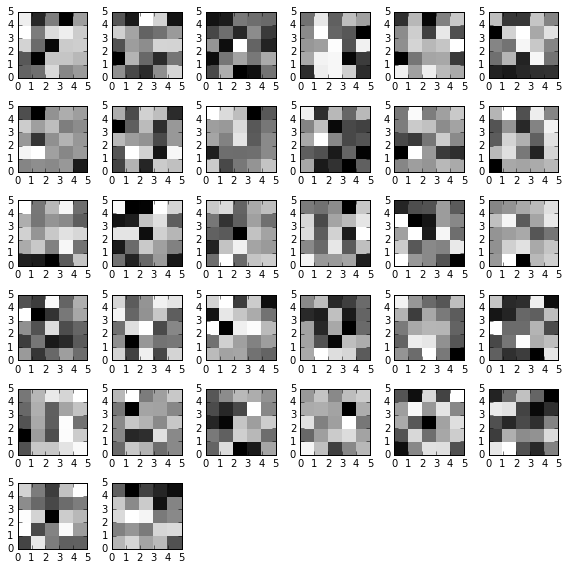

In [8]:
print(W1.shape)

plotLayerRaw(W1)

Yes, it is the same

## Making a protobuf to save model

## ... Can't get to work [!]

In [1]:
def create_network():
    """Creates graph as fxn"""
    
    n_features = 784
    n_labels = 10
    width = 28

    X = tf.placeholder(tf.float32, [None, n_features], name='X')
    Y = tf.placeholder(tf.float32, [None, n_labels], name='Y')

    # Need to reshape b/c doing convolutions
    X_tensor = tf.reshape(X, [-1, width, width, 1])

    # Define first layer
    filter_size = 5
    n_filters_in = 1
    n_filters_out = 32

    W_1 = tf.get_variable(
        name='W',
        shape=[filter_size, filter_size, n_filters_in, n_filters_out],
        initializer=tf.random_normal_initializer())

    b_1 = tf.get_variable(
        name='b',
        shape=[n_filters_out],
        initializer=tf.constant_initializer())

    h_1 = tf.nn.relu(
        tf.nn.bias_add(
            tf.nn.conv2d(input=X_tensor,
                         filter=W_1,
                         strides=[1, 2, 2, 1],
                         padding='SAME'),
                        b_1))

    # Define second layer
    n_filters_in = 32
    n_filters_out = 64

    W_2 = tf.get_variable(
        name='W2',
        shape=[filter_size, filter_size, n_filters_in, n_filters_out],
        initializer=tf.random_normal_initializer())

    b_2 = tf.get_variable(
        name='b2',
        shape=[n_filters_out],
        initializer=tf.constant_initializer())

    h_2 = tf.nn.relu(
        tf.nn.bias_add(
            tf.nn.conv2d(input=h_1,
                     filter=W_2,
                     strides=[1, 2, 2, 1],
                     padding='SAME'),
                     b_2))

    # Now connect to a fully-connected/linear layer:
    magicNum = 7  # ??
    h_2_flat = tf.reshape(h_2, [-1, magicNum * magicNum * n_filters_out])

    n_out = 128
    h_3, W = linearLayer(h_2_flat, n_out, activation=tf.nn.relu, name='fc_1')

    # And one final FC layer & softmax to get probs
    Y_pred, W = linearLayer(h_3, n_labels, activation=tf.nn.softmax, name='fc_2')

    # Define loss fxn in same way
    cross_entropy = -tf.reduce_sum(Y * tf.log(Y_pred + 1e-12))
    optimizer = tf.train.AdamOptimizer().minimize(cross_entropy)

    # with accuracy for our monitoring
    correct_prediction = tf.equal(tf.argmax(Y_pred, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

In [4]:
# define some things
path_protob_save = '/Users/kateniehaus/Dropbox/machine learning/Deep/Kadenze/'
fname_protob = 'testModel_tutorial3'
output_nodes = ['Y']   #  name of output node
ckpt_name = "/Users/kateniehaus/Dropbox/machine learning/Deep/Kadenze/model_4layerconvnet-mnist.ckpt"

In [20]:
graph_util.convert_variables_to_constants?

In [5]:
# convert variables to constants
g_1 = tf.Graph()
with tf.Session(graph=g_1) as sess:
    #x = tf.placeholder(tf.float32, shape=(1, 224, 224, 3))
    # Code to create graph
    net = create_network()
    sess.run(tf.initialize_all_variables())
    # restore from checkpoint
    saver = tf.train.Saver()
    saver.restore(sess, ckpt_name)
    # convert variables to constants
    graph_def = graph_util.convert_variables_to_constants(sess, sess.graph_def, output_nodes)

Converted 0 variables to const ops.


In [8]:
# save as protobuf
g_2 = tf.Graph()
with tf.Session(graph=g_2) as sess:
    tf.train.write_graph(
        graph_util.extract_sub_graph(
            graph_def, output_nodes), path_protob_save, fname_protob, as_text=False)

In [5]:
tf.import_graph_def?

In [6]:
# import model again
fname_protob_whole = '/Users/kateniehaus/Dropbox/machine learning/Deep/Kadenze/testModel_tutorial3'

with open(fname_protob_whole, mode='rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

tf.import_graph_def(graph_def, name='model')

In [7]:
# check graph output 
sess = tf.Session()
sess.run(tf.initialize_all_variables())
W1 = sess.run(W_1)
print(W1.shape)
plotLayerRaw(W1)

NameError: name 'W_1' is not defined